In [1]:

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.preprocessing import StandardScaler


In [7]:
# mapping labels to 0 to 3 for all the four classes
labmap = {0: "n02089078-black-and-tan_coonhound"
          ,1: "n02091831-Saluki"
          ,2:"n02092002-Scottish_deerhound"
          ,3:"n02095314-wire-haired_fox_terrier"} 

# giving the paths of the cropped images 
paths = [r'../DataSet/ProcessedDatasets/n02089078-black-and-tan_coonhound/'
         ,r'../DataSet/ProcessedDatasets/n02091831-Saluki/'
         ,r'../DataSet/ProcessedDatasets/n02092002-Scottish_deerhound/'
         ,r'../DataSet/ProcessedDatasets/n02095314-wire-haired_fox_terrier/']


data_set = [] # empty array to save the dataset
labels = [] # empty array to save the labels

# 1. loop to convert the images to gray scale pixel intensity histograms and save the labels and the dataset
for i in paths:
    for dog in os.listdir(i):
        img = cv2.imread(i + dog,cv2.IMREAD_GRAYSCALE)
        hist = cv2.calcHist(img, [0], None, [256], [0, 256])
        data_set.append(hist)
        labels.append(paths.index(i))

labels = np.array(labels)
# final data that consists of the normalized data and labels.
final_data = np.column_stack((np.array(data_set)[:,:,0], labels))

In [9]:
from sklearn.model_selection import train_test_split

# referred from https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

X_train, X_test, Y_train, Y_test = [], [], [], []
# 3. loop to split training and testing data to 80/20 percent
for i in labmap.keys():
    class_indices = np.where(labels == i)[0]
    X_class = final_data[class_indices]
    y_class = labels[class_indices]
    X_train_class, X_test_class, Y_train_class, Y_test_class = train_test_split(X_class, y_class, test_size=0.2)
    X_train.extend(X_train_class)
    X_test.extend(X_test_class)
    Y_train.extend(Y_train_class)
    Y_test.extend(Y_test_class)

X_train = np.array(X_train)
X_train = StandardScaler().fit_transform(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)


<h1>Standard 5-Fold cross-validation

In [10]:
from sklearn.model_selection import cross_val_score, KFold,StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

# list of k values to iterate through
k_values = [1, 3, 5, 7, 10, 20]

# Lists of validation and training errors for standard KFold cross-validation
standard_validation_errors = []
standard_training_errors = []

num_folds = 5

# Initialize a KFold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=57)

for k in k_values:
    # creating a k-NN classifier with the current k value
    knn_standard = KNeighborsClassifier(n_neighbors=k)
    
    # Initialize error variables for this k value
    validation_errors_k = []
    training_errors_k = []

    for train_index, validation_index in kf.split(X_train):
        
        # Split the data into training and validation sets
        X_train_fold, X_validation_fold = X_train[train_index], X_train[validation_index]
        Y_train_fold, Y_validation_fold = Y_train[train_index], Y_train[validation_index]

        # Fit the k-NN classifier on the training data
        knn_standard.fit(X_train_fold, Y_train_fold)

        # Predict on the training and validation sets
        Y_pred_train = knn_standard.predict(X_train_fold)
        Y_pred_validation = knn_standard.predict(X_validation_fold)

        # Calculate training and validation errors for this fold
        training_errors_k.append(1 - (Y_pred_train == Y_train_fold).mean())
        validation_errors_k.append(1 - (Y_pred_validation == Y_validation_fold).mean())

    # Calculate the mean errors across all folds for this k value
    mean_training_error = np.mean(training_errors_k)
    mean_validation_error = np.mean(validation_errors_k)

    # Append errors to the respective lists
    standard_training_errors.append(mean_training_error)
    standard_validation_errors.append(mean_validation_error)


<h1>Stratified 5-Fold cross-validation

In [11]:
import math
# Lists of validation and training errors for stratified 5-fold cross-validation
stratified_validation_errors = []
stratified_training_errors = []
best_k_values = [] 

# reffered from https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold.split

kfs = StratifiedKFold(n_splits=num_folds,shuffle=True,random_state=57)

for k in k_values:
    validation_errors = []
    training_errors = []
    # loop to split the train dataset into stratified 5 fold validation sets 
    for train_index, val_index in kfs.split(X_train, Y_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index] # Getting training data and validation data
        Y_train_fold, Y_val_fold = Y_train[train_index], Y_train[val_index] # Getting training labels and validation labels

        knn_stratified = KNeighborsClassifier(n_neighbors=k) 
        knn_stratified.fit(X_train_fold, Y_train_fold)

        y_pred_train = knn_stratified.predict(X_train_fold)
        y_pred_val = knn_stratified.predict(X_val_fold)


        validation_errors.append(1- (y_pred_val == Y_val_fold).mean())
        training_errors.append(1- (y_pred_train == Y_train_fold).mean())

    mean_validation_error = np.mean(validation_errors)
    mean_training_error = np.mean(training_errors)

    stratified_validation_errors.append(mean_validation_error)
    stratified_training_errors.append(mean_training_error)

    best_k = k_values[np.argmin(stratified_validation_errors)]
    best_k_values.append(best_k)

print(f'validation errors  = {stratified_validation_errors}')
print(f'training errors  = {stratified_training_errors}')


validation errors  = [0.6884033613445378, 0.6466946778711484, 0.6516666666666666, 0.6498319327731092, 0.6599439775910365, 0.6398739495798319]
training errors  = [0.0, 0.37605764760576477, 0.4250554809961141, 0.45729849214494356, 0.4920502092050209, 0.5389393261580835]


<h3> Plotting the validation and training errors for both the cross-validations

K with the least Standard Validation Error: 5
K with the least Standard Training Error: 1
K with the least Stratified Validation Error: 20
K with the least Stratified Training Error: 1


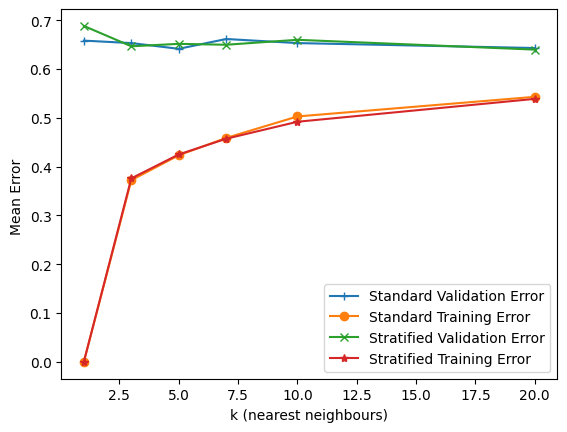

In [12]:
import matplotlib.pyplot as plt



# Plot the validation and training error curves for standard 5-fold cross-validation
plt.plot(k_values, standard_validation_errors, label='Standard Validation Error', marker='+')
plt.plot(k_values, standard_training_errors, label='Standard Training Error', marker='o')

# Plot the validation and training error curves for stratified 5-fold cross-validation
plt.plot(k_values, stratified_validation_errors, label='Stratified Validation Error', marker='x')
plt.plot(k_values, stratified_training_errors, label='Stratified Training Error', marker='*')

# Label the axes and add a legend
plt.xlabel('k (nearest neighbours)')
plt.ylabel('Mean Error ')
plt.legend()

# Find the best k for each curve
best_k_standard_validation = k_values[standard_validation_errors.index(min(standard_validation_errors))]
best_k_standard_training = k_values[standard_training_errors.index(min(standard_training_errors))]
best_k_stratified_validation = k_values[stratified_validation_errors.index(min(stratified_validation_errors))]
best_k_stratified_training = k_values[stratified_training_errors.index(min(stratified_training_errors))]

# Print the best k values for each curve
print(f'K with the least Standard Validation Error: {best_k_standard_validation}')
print(f'K with the least Standard Training Error: {best_k_standard_training}')
print(f'K with the least Stratified Validation Error: {best_k_stratified_validation}')
print(f'K with the least Stratified Training Error: {best_k_stratified_training}')

# Show the plot
plt.show()



<h1> Comments</h1>
</br>
<p1>7 nearest neighbours has the least mean validation error for stratified cross fold validations
</br>
<p1>10 nearest neighbours has the least mean validation error for standard cross fold validations
</br>
<p1>1 nearest neighbours has the least mean training error for both standard and stratified cross fold validations
</br>
<p1>1 nearest neighbours has the least mean training error for both standard and stratified cross fold validations
</br>
K values       ||     Complexity           ||            Fit Type
</br>
1              ||    more complex          ||            overfit
</br>
3              ||     more complex                ||            overfit
</br>
5              ||     more complex               ||           overfit
</br>
7              ||     complex  ||           overfit
</br>
10             ||    less compex   ||          underfit
</br>
20             ||     complex      ||           underfit

In [13]:
knn_s = KNeighborsClassifier(n_neighbors=best_k_stratified_validation)

# Train the k-NN classifier on the entire training dataset
knn_s.fit(X_train, Y_train)

# Evaluate the model on the test dataset and calculate the test error
Y_pred_test = knn_s.predict(X_test)
test_error = 1 - (Y_pred_test == Y_test).mean()  # Test error in terms of misclassification rate

print(f'Test Error with k={best_k_stratified_validation}: {test_error * 100:.2f}%')

Test Error with k=20: 65.56%


c:\Users\kaasa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\kaasa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\kaasa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\kaasa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

Confusion Matrix - Naive Bayes
[[ 0.  0. 32.  0.]
 [ 0.  0.  0. 40.]
 [ 0.  0.  0. 47.]
 [ 0.  0.  0. 32.]]
32.0 Average correct prediction for Naive Bayes on stratified 5 fold on test dataset.
Confusion Matrix - Neural Network
[[ 5.6 10.  12.4  4. ]
 [ 2.6  6.8 18.  12.6]
 [ 1.8  5.6 25.4 14.2]
 [ 1.4  4.  11.6 15. ]]
52.8 Average correct prediction for Neural Network on stratified 5 fold on test dataset.
Confusion Matrix - Random Forest
[[ 0.   0.2 31.6  0.2]
 [ 0.2  0.  11.8 28. ]
 [ 0.   0.  18.4 28.6]
 [ 0.   0.   5.4 26.6]]
45.0 Average correct prediction for Random Forest on stratified 5 fold on test dataset.


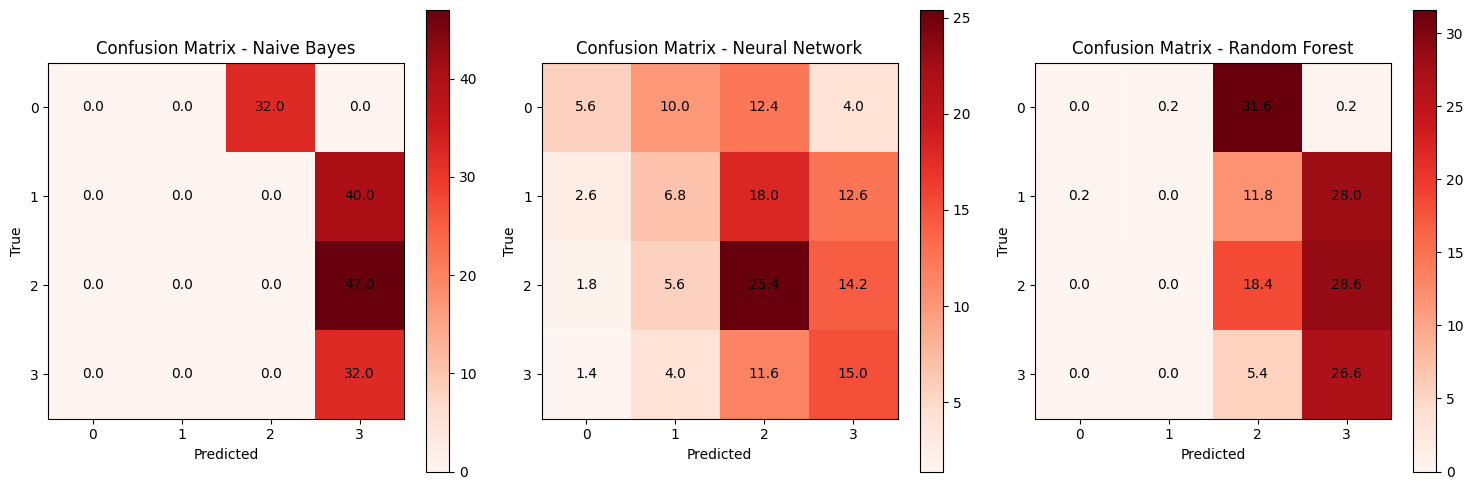

Best model according to confusion matrices is Neural Network with average accuracy of 52.8


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
# reffered from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html


class_labels = np.unique(Y_train)  

naive_bayes = GaussianNB()
neural_network = MLPClassifier(hidden_layer_sizes=(10, 10, 10))
random_forest = RandomForestClassifier()

models = [naive_bayes, neural_network, random_forest]
model_names = ['Naive Bayes', 'Neural Network', 'Random Forest']

skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=57)

confusion_matrices = []
confusion_matrices_test = []

for model, model_name in zip(models, model_names):
    fold_matrices = [] 
    for train_index, tv_index in skf.split(X_train, Y_train):
        X_train_fold, X_tv_fold = X_train[train_index], X_train[tv_index]
        Y_train_fold, y_tv_fold = Y_train[train_index], Y_train[tv_index]

        model.fit(X_train_fold, Y_train_fold)

        Y_test_pred = model.predict(X_test)   # predictions based on validation set
        fold_matrix = confusion_matrix(Y_test, Y_test_pred, labels=class_labels) # confusion matrix based on validation set.
        fold_matrices.append(fold_matrix)
        
    confusion_matrices.append(fold_matrices)

best_model = ""
best_accuracy = 0
plt.figure(figsize=(15, 5))
for i, model_name in enumerate(model_names):
    plt.subplot(1, 3, i + 1)
    average_matrix = np.mean(confusion_matrices[i], axis=0)
    plt.imshow(average_matrix, cmap=plt.cm.Reds)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.colorbar()
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels)
    plt.yticks(tick_marks, class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')

    for i in range(len(class_labels)):
        for j in range(len(class_labels)):
            plt.text(j, i, f'{average_matrix[i, j]}', ha='center', va='center', color='black')
            
    print(f'Confusion Matrix - {model_name}')
    print(average_matrix)
    sum = 0
    for i in range(len(average_matrix)):
        for j in range(len(average_matrix[0])):
            if i==j:
                sum+=average_matrix[i,j]
    print(f'{sum} Average correct prediction for {model_name} on stratified 5 fold on test dataset.')
    if(sum>best_accuracy):
        best_accuracy = sum
        best_model = model_name


plt.tight_layout()
plt.show()

print(f"Best model according to confusion matrices is {best_model} with average accuracy of {best_accuracy}")


In [15]:
from sklearn.metrics import accuracy_score, f1_score

y_true = Y_test

models[0].fit(X_train,Y_train)
models[1].fit(X_train,Y_train)
models[2].fit(X_train,Y_train)

y_pred_naive_bayes = models[0].predict(X_test)
y_pred_neural_network = models[1].predict(X_test)
y_pred_random_forest = models[2].predict(X_test)

accuracy_naive_bayes = accuracy_score(y_true, y_pred_naive_bayes)
accuracy_neural_network = accuracy_score(y_true, y_pred_neural_network)
accuracy_random_forest = accuracy_score(y_true, y_pred_random_forest)

f1_naive_bayes = f1_score(y_true, y_pred_naive_bayes, average='weighted')
f1_neural_network = f1_score(y_true, y_pred_neural_network, average='weighted')
f1_random_forest = f1_score(y_true, y_pred_random_forest, average='weighted')

print(f"Test Accuracy - Naive Bayes: {accuracy_naive_bayes * 100:.2f}%")
print(f"Test Accuracy - Neural Network: {accuracy_neural_network * 100:.2f}%")
print(f"Test Accuracy - Random Forest: {accuracy_random_forest * 100:.2f}%")

print(f"F-Measure - Naive Bayes: {f1_naive_bayes:.4f}")
print(f"F-Measure - Neural Network: {f1_neural_network:.4f}")
print(f"F-Measure - Random Forest: {f1_random_forest:.4f}")


c:\Users\kaasa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Test Accuracy - Naive Bayes: 21.19%
Test Accuracy - Neural Network: 33.77%
Test Accuracy - Random Forest: 29.80%
F-Measure - Naive Bayes: 0.0898
F-Measure - Neural Network: 0.3335
F-Measure - Random Forest: 0.2025


Random forest is the best classification according to test Accuracy. 
</br>
Random forest is the best classification according to F-measure

<h1>References:</h1>

1. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
</br>
2. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold.split
</br>
3. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html